In [2]:
# 卷积网络的训练数据为MNIST
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
import warnings
warnings.filterwarnings('ignore')

In [3]:
train_epochs    = 2     # 训练轮数
batch_size      = 100     # 随机抽取数据大小
display_step    = 1       # 显示训练结果的间隔
learning_rate   = 0.0001  # 学习效率
fch_nodes       = 512     # 全连接隐藏层神经元的个数
train_keep_prob = 0.5     # 全连接层正则化参数
c1_kernel       = [5, 5, 1, 16]
c2_kernel       = [5, 5, 16, 32]
p1_ksize        = [1, 2, 2, 1]
p2_ksize        = [1, 2, 2, 1]

In [2]:
# 训练参数
train_epochs    = 100     # 训练轮数
batch_size      = 100     # 随机抽取数据大小
display_step    = 1       # 显示训练结果的间隔
learning_rate   = 0.0001  # 学习效率
fch_nodes       = 512     # 全连接隐藏层神经元的个数
train_keep_prob = 0.5     # 全连接层正则化参数
c1_kernel       = [5, 5, 1, 16]
c2_kernel       = [5, 5, 16, 32]
p1_ksize        = [1, 2, 2, 1]
p2_ksize        = [1, 2, 2, 1]

In [3]:
# 卷积网络结构
# 输入层为输入的灰度图像尺寸:  -1 x 28 x 28 x 1 
# 第一个卷积层,卷积核的大小,深度和数量 (5, 5, 1, 16)
# 池化后的特征张量尺寸:       -1x 14 x 14 x 16
# 第二个卷积层,卷积核的大小,深度和数量 (5, 5, 16, 32)
# 池化后的特征张量尺寸:       -1 x 7 x 7 x 32
# 全连接层权重矩阵         1568 x 512
# 输出层与全连接隐藏层之间,  512 x 10

In [4]:
# 网络模型需要的一些辅助函数
# 权重初始化(卷积核初始化)
# tf.truncated_normal()不同于tf.random_normal(),返回的值中不会偏离均值两倍的标准差
# 参数shpae为一个列表对象,例如[5, 5, 1, 32]对应
# 5,5 表示卷积核的大小, 1代表通道channel,对彩色图片做卷积是3,单色灰度为1
# 最后一个数字32,卷积核的个数,(也就是卷基层提取的特征数量)
#   显式声明数据类型,切记
def weight_init(shape):
    weights = tf.truncated_normal(shape, stddev=0.1,dtype=tf.float32)
    return tf.Variable(weights)

# 偏置的初始化
def biases_init(shape):
    biases = tf.random_normal(shape,dtype=tf.float32)
    return tf.Variable(biases)

# 随机选取mini_batch
def get_random_batchdata(n_samples, batchsize):
    start_index = np.random.randint(0, n_samples - batchsize)
    return (start_index, start_index + batchsize)

In [5]:
# 全连接层权重初始化函数xavier
def xavier_init(layer1, layer2, constant = 1):
    Min = -constant * np.sqrt(6.0 / (layer1 + layer2))
    Max = constant * np.sqrt(6.0 / (layer1 + layer2))
    return tf.Variable(tf.random_uniform((layer1, layer2), minval = Min, maxval = Max, dtype = tf.float32))

In [6]:
# 卷积
def conv2d(x, w):
    return tf.nn.conv2d(x, w, strides=[1, 1, 1, 1], padding='SAME')

# 源码的位置在tensorflow/python/ops下nn_impl.py和nn_ops.py
# 这个函数接收两个参数,x 是图像的像素, w 是卷积核
# x 张量的维度[batch, height, width, channels]
# w 卷积核的维度[height, width, channels, channels_multiplier]
# tf.nn.conv2d()是一个二维卷积函数,
# stirdes 是卷积核移动的步长,4个1表示,在x张量维度的四个参数上移动步长
# padding 参数'SAME',表示对原始输入像素进行填充,卷积后映射的2D图像与原图大小相等
# 填充,是指在原图像素值矩阵周围填充一圈0像素点
# 如果不进行填充,假设 原图为 32x32 的图像,卷积和大小为 5x5 ,卷积后映射图像大小 为 28x28

In [7]:
# 池化
def max_pool_2x2(x, ksize):
    return tf.nn.max_pool(x, ksize= ksize, strides=[1, 2, 2, 1], padding='SAME')

# 池化跟卷积的情况有点类似
# x 是卷积后,有经过非线性激活后的图像,
# ksize 是池化滑动张量
# ksize 的维度[batch, height, width, channels],跟 x 张量相同
# strides [1, 2, 2, 1],与上面对应维度的移动步长
# padding与卷积函数相同,padding='VALID',对原图像不进行0填充

In [8]:
# x 是手写图像的像素值,y 是图像对应的标签
x = tf.placeholder(tf.float32, [None, 784])
y = tf.placeholder(tf.float32, [None, 10])
# 把灰度图像一维向量,转换为28x28二维结构
x_image = tf.reshape(x, [-1, 28, 28, 1])
# -1表示任意数量的样本数,大小为28x28深度为一的张量
# 可以忽略(其实是用深度为28的,28x1的张量,来表示28x28深度为1的张量)

In [9]:
# 第一层卷积+池化
w_conv1 = weight_init(c1_kernel)                             # 5x5,深度为1,16个
b_conv1 = biases_init([c1_kernel[-1]])
h_conv1 = tf.nn.relu(conv2d(x_image, w_conv1) + b_conv1)    # 输出张量的尺寸:28x28x16
h_pool1 = max_pool_2x2(h_conv1, p1_ksize)                       # 池化后张量尺寸:14x14x16
# h_pool1 , 14x14的16个特征图

In [10]:
# 第二层卷积+池化
w_conv2 = weight_init(c2_kernel)                             # 5x5,深度为16,32个
b_conv2 = biases_init([c2_kernel[-1]])
h_conv2 = tf.nn.relu(conv2d(h_pool1, w_conv2) + b_conv2)    # 输出张量的尺寸:14x14x32
h_pool2 = max_pool_2x2(h_conv2, p2_ksize)                                   # 池化后张量尺寸:7x7x32
# h_pool2 , 7x7的32个特征图

In [11]:
# 全连接层
# h_pool2是一个7x7x32的tensor,将其转换为一个一维的向量
h_fpool2 = tf.reshape(h_pool2, [-1, 7*7*32])
# 全连接层,隐藏层节点为512个
# 权重初始化
w_fc1 = xavier_init(7*7*32, fch_nodes)
b_fc1 = biases_init([fch_nodes])
h_fc1 = tf.nn.relu(tf.matmul(h_fpool2, w_fc1) + b_fc1)

In [12]:
# 全连接隐藏层/输出层
# 为了防止网络出现过拟合的情况,对全连接隐藏层进行 Dropout(正则化)处理,在训练过程中随机的丢弃部分
# 节点的数据来防止过拟合.Dropout同把节点数据设置为0来丢弃一些特征值,仅在训练过程中,
# 预测的时候,仍使用全数据特征
# 传入丢弃节点数据的比例
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# 隐藏层与输出层权重初始化
w_fc2 = xavier_init(fch_nodes, 10)
b_fc2 = biases_init([10])

# 未激活的输出
y_ = tf.add(tf.matmul(h_fc1_drop, w_fc2), b_fc2)
# 激活后的输出
y_out = tf.nn.softmax(y_)

In [13]:
# 交叉熵代价函数
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y * tf.log(y_out), reduction_indices = [1]))

# tensorflow自带一个计算交叉熵的方法
# 输入没有进行非线性激活的输出值 和 对应真实标签
#cross_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_, y))

# 优化器选择Adam(有多个选择)
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)

# 准确率
# 每个样本的预测结果是一个(1,10)的vector
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_out, 1))
# tf.cast把bool值转换为浮点数
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [14]:
# 全局变量进行初始化的Operation
init = tf.global_variables_initializer()

In [15]:
# 加载数据集MNIST
mnist = input_data.read_data_sets('MNIST/mnist', one_hot=True)
n_samples = int(mnist.train.num_examples)
#total_batches = int(n_samples / batch_size)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST/mnist/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST/mnist/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST/mnist/t10k-images-idx3-ubyte.gz
Extracting MNIST/mnist/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [16]:
sess = tf.Session()
sess.run(init)

In [17]:
Train_cost = []

for i in range(train_epochs):
    # 随机抽取batch data 的次数
    for j in range(50):
        start_index, end_index = get_random_batchdata(n_samples, batch_size)
            
        batch_x = mnist.train.images[start_index: end_index]
        batch_y = mnist.train.labels[start_index: end_index]
        _ , cost= sess.run([ optimizer,cross_entropy], feed_dict={x:batch_x, y:batch_y,keep_prob:train_keep_prob})
        Train_cost.append(cost)
    
    if i % display_step ==0:
        print ('Epoch : %d , Train cost: %.7f'%(i+10,cost))
print 'training finished'

Epoch : 10 , Train cost: 2.3045609
Epoch : 11 , Train cost: 1.9697182
training finished


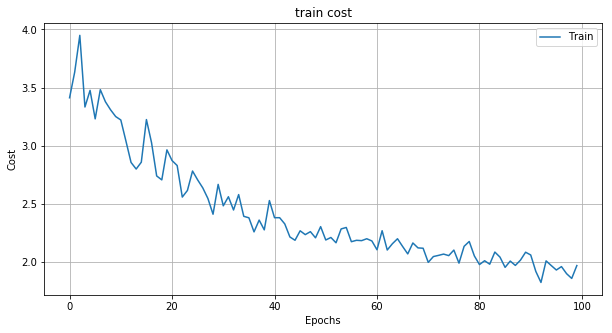

In [18]:
# 学习曲线
fig2,ax2 = plt.subplots(figsize=(10,5))
plt.plot(Train_cost, label='Train')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Cost')
plt.title('train cost')
plt.legend()
plt.grid()
plt.show()

In [ ]:
Test 结果

In [19]:
accu = sess.run(accuracy, feed_dict={x:mnist.test.images[:3000],y:mnist.test.labels[:3000] , keep_prob:1.0})
    
print ('Test result is: %.7f'%(accu))

Test result is: 0.6373333


input image的可视化

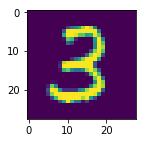

In [20]:
# imput image
fig2,ax2 = plt.subplots(figsize=(2,2))
ax2.imshow(np.reshape(mnist.train.images[11], (28, 28)))
plt.show()

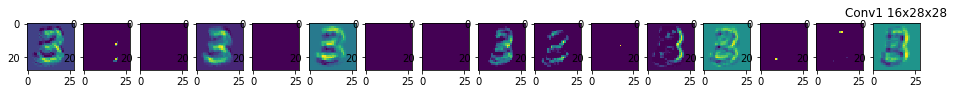

In [21]:
# 第一层的卷积输出的特征图
input_image = mnist.train.images[11:12]
conv1_16 = sess.run(h_conv1, feed_dict={x:input_image})          # [16, 28, 28 ,1] 
conv1_transpose = sess.run(tf.transpose(conv1_16, [3,0,1,2]))
fig3,ax3 = plt.subplots(nrows=1, ncols=16, figsize = (16,1))
for i in range(16):
    ax3[i].imshow(conv1_transpose[i][0])                          # tensor的切片[batch, channels, row, column] 
plt.title('Conv1 16x28x28')
plt.show()

In [22]:
conv1_16.shape

(1, 28, 28, 16)

In [23]:
conv1_transpose.shape

(16, 1, 28, 28)

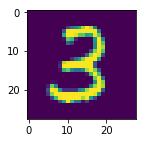

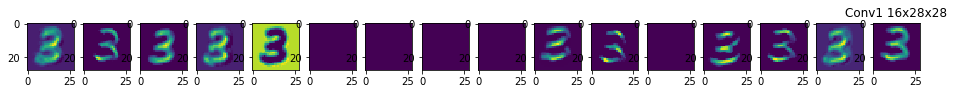

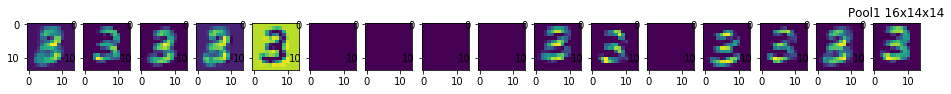

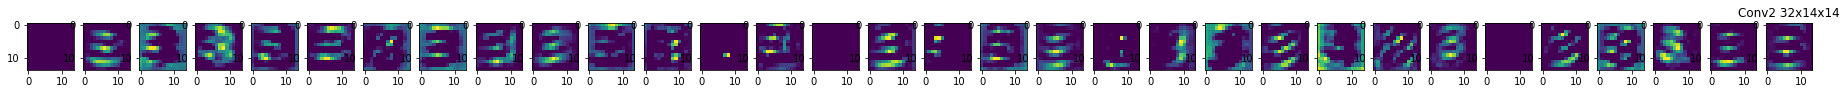

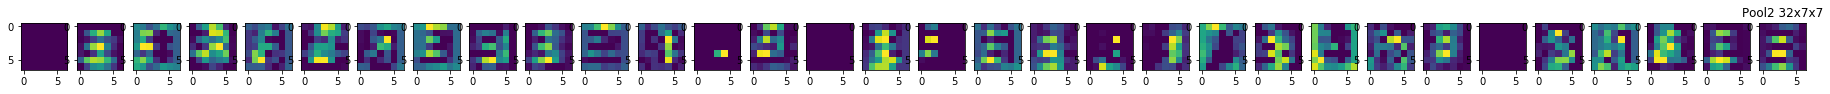

In [41]:
# imput image
fig2,ax2 = plt.subplots(figsize=(2,2))
ax2.imshow(np.reshape(mnist.train.images[11], (28, 28)))
plt.show()

#第一个卷基层

# 第一层的卷积输出的特征图
input_image = mnist.train.images[11:12]
conv1_16 = sess.run(h_conv1, feed_dict={x:input_image})          # [16, 28, 28 ,1] 
conv1_transpose = sess.run(tf.transpose(conv1_16, [3,0,1,2]))
fig3,ax3 = plt.subplots(nrows=1, ncols=16, figsize = (16,1))
for i in range(16):
    ax3[i].imshow(conv1_transpose[i][0][:,:])                          # tensor的切片[batch, channels, row, column] 
plt.title('Conv1 16x28x28')
plt.show()



#第一个池化层

# 第一层池化后的特征图
pool1_16 = sess.run(h_pool1, feed_dict={x:input_image})          # [16, 14, 14, 1]
pool1_transpose = sess.run(tf.transpose(pool1_16, [3,0,1,2]))
fig4,ax4 = plt.subplots(nrows=1, ncols=16, figsize=(16,1))
for i in range(16):
    ax4[i].imshow(pool1_transpose[i][0])
plt.title('Pool1 16x14x14')
plt.show()

#第二层卷积

# 第二层卷积输出特征图
conv2_32 = sess.run(h_conv2, feed_dict={x:input_image})          # [32, 14, 14, 1]
conv2_transpose = sess.run(tf.transpose(conv2_32, [3,0,1,2]))
fig5,ax5 = plt.subplots(nrows=1, ncols=32, figsize = (32, 2))
for i in range(32):
    ax5[i].imshow(conv2_transpose[i][0])
plt.title('Conv2 32x14x14')
plt.show()

#第二层池化

# 第二层池化后的特征图
pool2_32 = sess.run(h_pool2, feed_dict={x:input_image})          # [32, 7, 7, 1]
pool2_transpsoe = sess.run(tf.transpose(pool2_32, [3,0,1,2]))
fig6,ax6 = plt.subplots(nrows=1, ncols=32, figsize = (32, 1))
plt.title('Pool2 32x7x7')
for i in range(32):
    ax6[i].imshow(pool2_transpsoe[i][0])
plt.show()

In [88]:
sess.close()

In [ ]:
images = []
for i in range(1000):
    image = plt.imread('xxx/'+str(i)+'.jpg')
    images.append(image)
images = np.array(images)